# SUR Model

The linear SUR model involves a set of regression equations with cross-equation parameter restrictions and correlated error terms having differing variances. Algebraically, the
SUR model is given by:

$$y_j = X_j\beta_j + u_j, j = 1,...m, ~~\text{with}~~ E[u_iu_j^{T}] = \begin{cases} 
- \omega_{ij}I,\ \ \ (i \ne j) \\
- \omega_{i}^2I,\ \ \ (i = j) \\ 
\end{cases}$$

we can model the problem with :
$$ y = X\beta + u$$ 
where,
- $u \sim \mathcal{N}(0,\Omega⊗I)$ 
- $\Omega$ is m × m symmetric matrix with diagonal elements $\{\omega_1^2,...\omega_m^2\}$
- $X$ = diag{$X_1,...X_m$}

we can write the likehood function as :
$$L(y|\beta,\Omega) = \frac{1}{(2\pi)^{\frac{nm}{2}}|\Omega|^{\frac{n}{2}}}\exp[-\frac{1}{2}tr\{R\Omega^{-1}\}] $$
where $R = (r_{ij})$, $r_{ij} = (y_i - X_{i}\beta_i)^T(y_j - X_j\beta_j)$

# Markov chain Monte Carlo Approach

In this approach, we suppose that we don't have a prior knowledge on the parameters. Therefore, we use a Jeffrey's invariant prior :

$$ \pi(\beta,\Omega) = \pi(\beta)\pi(\Omega) ∝ |\Omega|^{-\frac{m+1}{2}} $$ 

Where m is the number of different values of $\beta$.

Using this prior, we can obtain the joint posterior density function :
$$\pi(\beta,\Omega|D) ∝ |\Omega|^{-\frac{n+m+1}{2}}\exp[(-\frac{1}{2}\{\text{tr}( R \Omega^{-1})\}]$$

We can deduce the conditional posteriors $\pi(\beta|\Omega,D)$ and $\pi(\Omega|\beta,D)$:

$$\beta|\Omega,D \sim \mathcal{N}(\hat \beta,\hat \Omega_\beta) ~~\text{and}~~ \Omega|\beta,D \sim IW(R,n)$$

where,

$\hat \beta = \{X^T(\Omega^{-1}⊗I)X\}^{-1}X^{T}(\Omega^{-1}⊗I)y$ 

$\hat \Omega_\beta = (X^{T}(\Omega^{-1}⊗I)X)^{-1}$

We will implement this method using gibbs sampler.

We start by $\beta_{0}$, $\Omega_{0}$.
At each step t :

- We generate a new value $\beta_{t}$ from $\mathcal{N}(\hat \beta_{t-1},\hat \Omega_{t-1})$.
- We generate a new value $\Omega_{t}$ from $IW(R_t,n)$


In [7]:
from utils import generate_SUR, Sampler, DefaultParams
import numpy as np
from numpy.linalg import inv
from scipy.stats import invwishart, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [8]:
# get the default parameters of SUR
params = DefaultParams()
params.print()

beta1 =  [ 3 -2]
beta2 =  [2 1]
omega =  [[ 0.1  -0.05]
 [-0.05  0.2 ]]
number of simulations for each model =  100


In [9]:
class MCMC_Sampler(Sampler):
    def __init__(self, SUR_data, num_iterations=11000, burn_in_steps=1000):
        super().__init__(SUR_data)
        self.num_iterations = num_iterations
        self.burn_in_steps = burn_in_steps

    def _sample_beta(self, omega):
        omega_inv = inv(omega)
        n = params.n
        omega_inv_tensor = np.block([
                        [omega_inv[0,0]*np.eye(n), omega_inv[0,1]*np.eye(n)],
                        [omega_inv[1,0]*np.eye(n), omega_inv[1,1]*np.eye(n)],
        ])
        X = self.SUR_data['X']
        Y = self.SUR_data['Y']
        X_transposed = np.transpose(X)
        beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
        omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
        beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
        return beta

    def _sample_omega(self, beta):
        y1 = self.SUR_data['Y'][:params.n]
        y2 = self.SUR_data['Y'][params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        m1 = y1 - x1 @ beta[:2].reshape(-1,1)
        m2 = y2 - x2 @ beta[2:].reshape(-1,1)
        R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
                      [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()]])
        omega = invwishart.rvs(df=params.n, scale=R)
        return omega

    def sample(self):
        beta_simu = []
        omega_simu = []
        omega = np.random.rand(2,2) # initialisation
        for _ in range(self.num_iterations):
            beta = self._sample_beta(omega)
            omega = self._sample_omega(beta)
            beta_simu.append(beta)
            omega_simu.append(omega)
        return np.array(beta_simu[self.burn_in_steps:]), np.array(omega_simu[self.burn_in_steps:])

In [10]:
mcmc_sampler = MCMC_Sampler(SUR_data=generate_SUR())
beta_simu, omega_simu = mcmc_sampler.sample()

In [34]:
def plot_beta(beta):
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(beta[:,0], label='beta1_1')
    plt.plot(np.ones(len(beta[:,0]))*params.beta1[0], label='real_beta1_1',linestyle = '-')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(beta[:,1], label='beta1_2')
    plt.plot(np.ones(len(beta[:,0]))*params.beta1[1], label='real_beta1_2',linestyle = '-')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(beta[:,2], label='beta2_1')
    plt.plot(np.ones(len(beta[:,0]))*params.beta2[0], label='real_beta2_1',linestyle = '-')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(beta[:,3], label='beta2_2')
    plt.plot(np.ones(len(beta[:,0]))*params.beta2[1], label='real_beta2_2',linestyle = '-')
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    plt.ylim(-3, 4)
    plt.legend()
    plt.show()

In [102]:
def plot_omega(omega):
    fig = plt.figure(figsize=(15, 15))
    
    plt.subplot(3, 2, 1)
    plt.plot(omega[:,0,0], label='omega1')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[0,0], label='real_omega1_1',linestyle = '-')
    plt.legend()
    
    plt.subplot(3,2,2)
    plt.hist(omega[:,0,0],weights = np.ones(len(omega[:,0,0]))/len(omega[:,0,0]), label='omega1')
    plt.vlines(x=params.omega[0,0],ymin=0,ymax=1,label = 'real_omega1_1',color = 'r')
    plt.legend()
    
    
    plt.subplot(3,2,3)
    plt.plot(omega[:,0,1], label='omega1_2')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[1,0], label='real_omega1_2',linestyle = '-')
    plt.legend()
    
    plt.subplot(3,2,4)
    plt.hist(omega[:,0,1], weights = np.ones(len(omega[:,0,1]))/len(omega[:,0,0]),label='omega1_2')
    plt.vlines(x=params.omega[0,1],ymin=0,ymax=1,label = 'real_omega1_2',color = 'r')
    plt.legend()
    
    plt.subplot(3,2,5)
    plt.plot(omega[:,1,1], label='omega2')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[1,1], label='real_omega2_2',linestyle = '-')
    
    plt.subplot(3,2,6)
    plt.hist(omega[:,1,1], weights = np.ones(len(omega[:,1,1]))/len(omega[:,1,1]),label='omega2_2')
    plt.vlines(x=params.omega[1,1],ymin=0,ymax=1,label = 'real_omega2_2',color = 'r')
    plt.legend()
    
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    plt.ylim(-0.1, 0.3)
    plt.legend()
    plt.show()

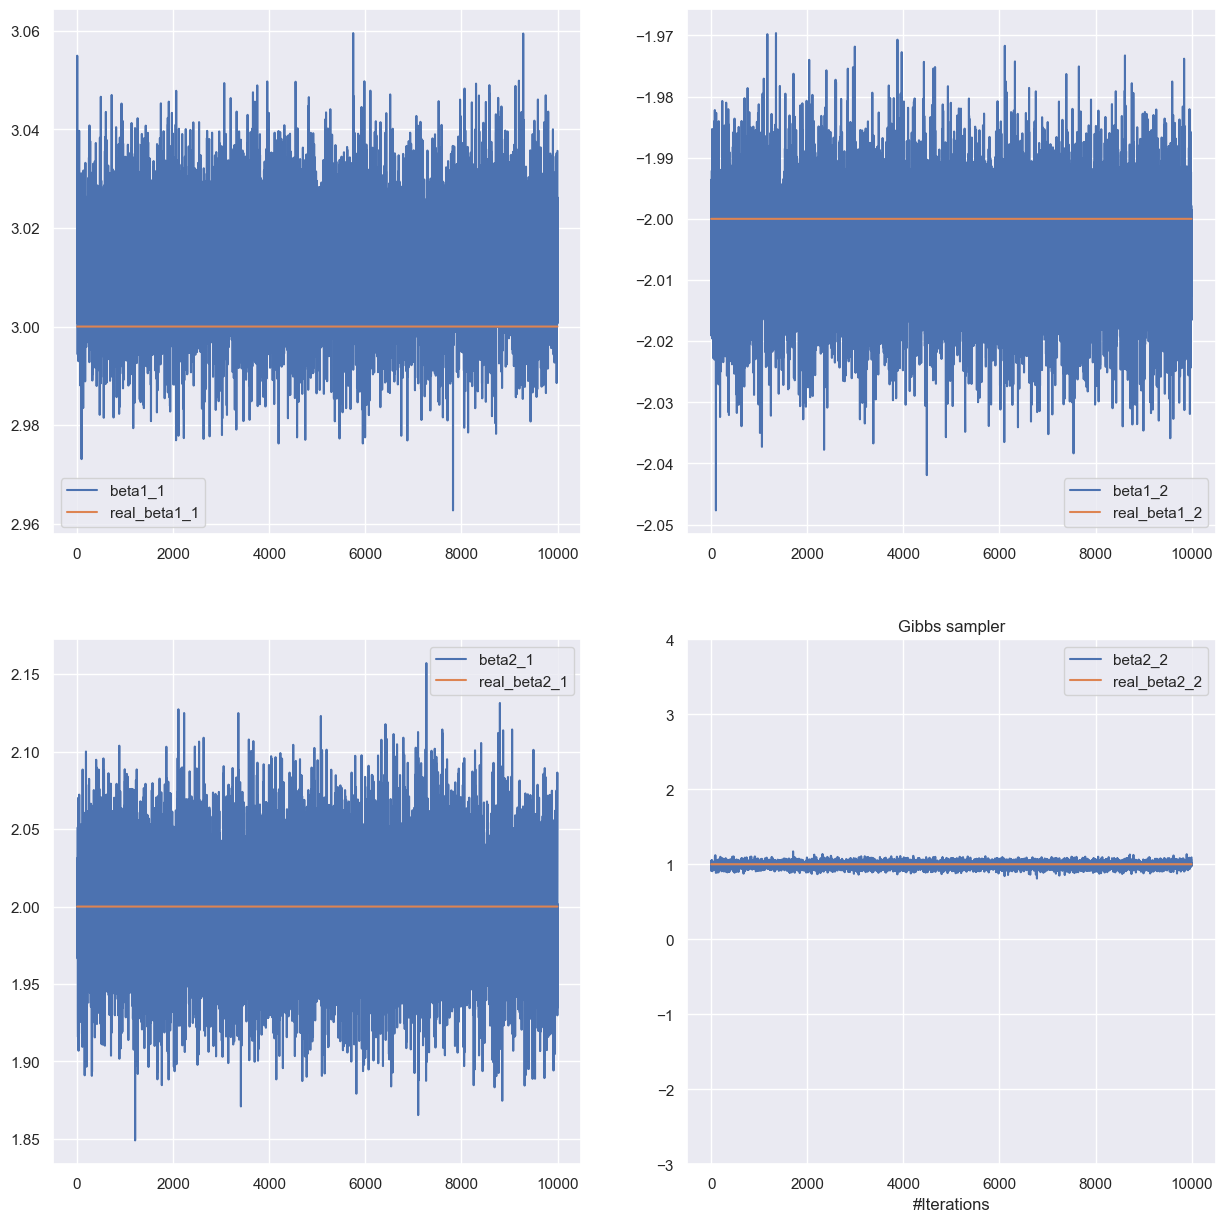

In [103]:
plot_beta(beta=beta_simu)

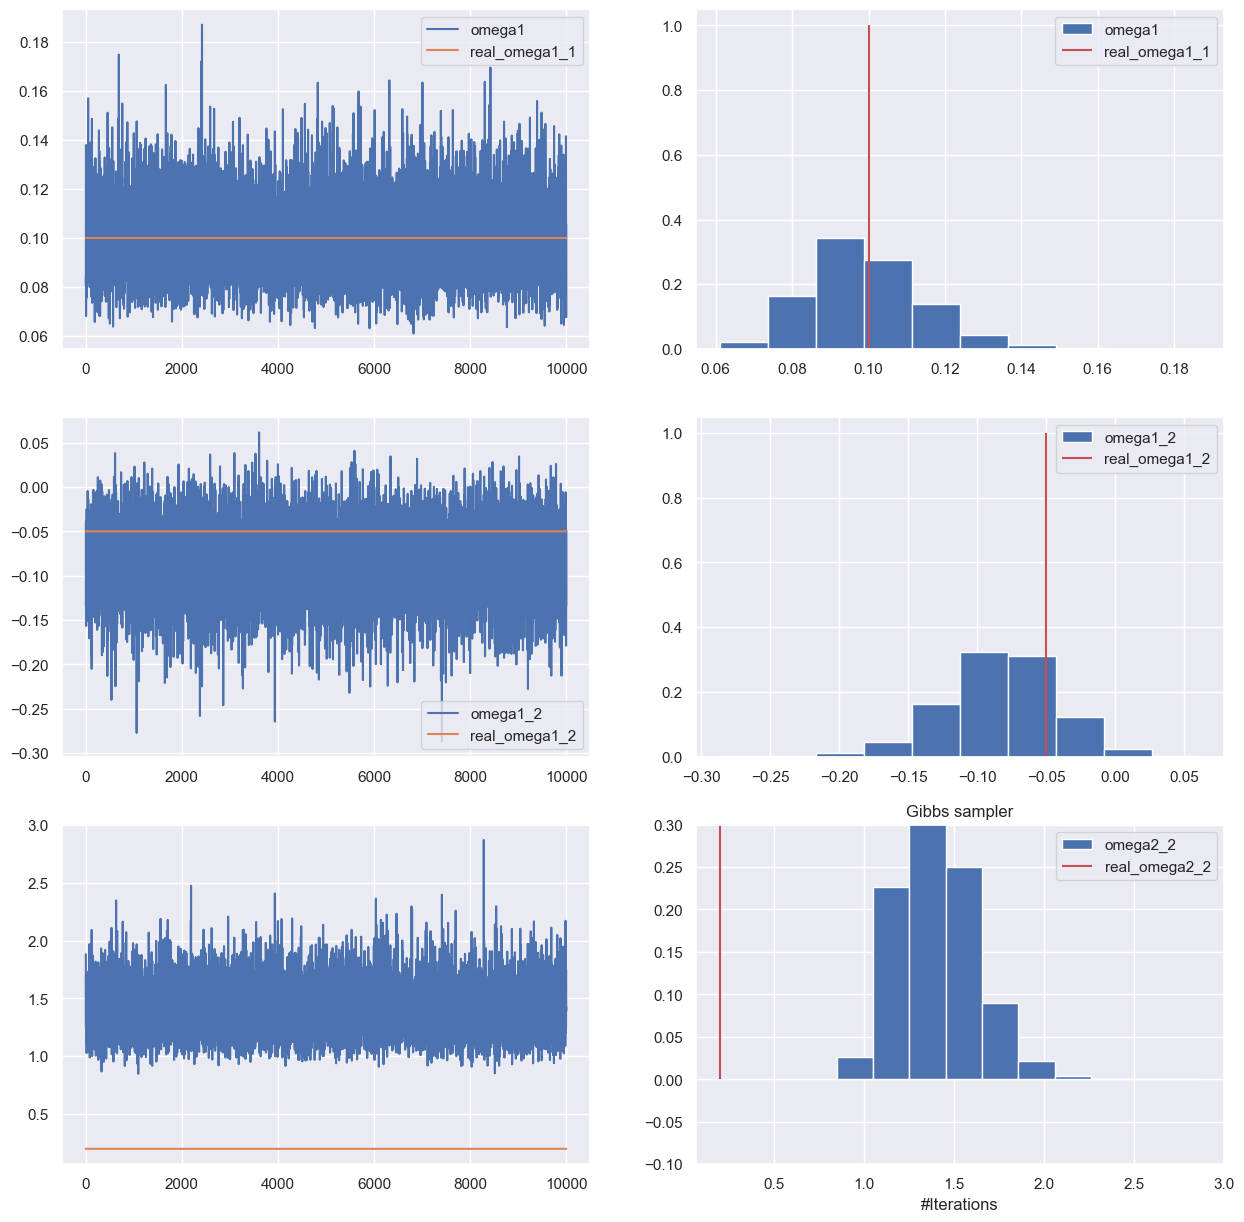

In [104]:
plot_omega(omega=omega_simu)

In [67]:
# def sample_beta(omega, data:generate_SUR):
#     omega_inv = inv(omega)
#     omega_inv_tensor = np.block([
#                     [omega_inv[0,0]*np.eye(params.n), omega_inv[0,1]*np.eye(params.n)],
#                     [omega_inv[1,0]*np.eye(params.n), omega_inv[1,1]*np.eye(params.n)],
#     ])
#     X = data['X']
#     Y = data['Y']
#     X_transposed = np.transpose(X)
#     beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
#     omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
#     beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
#     return beta
# def sample_omega(beta, data:generate_SUR):
#     y1 = data['Y'][:100]
#     y2 = data['Y'][100:]
#     x1 = data['x1']
#     x2 = data['x2']
#     m1 = y1 - x1 @ params.beta1
#     m2 = y2 - x2 @ params.beta2
#     R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
#                   [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()],])
#     omega = invwishart.rvs(df=params.n, scale=R)
#     return omega
# def sample(num_iterations=11000, burn_in_steps=1000):
#     beta_simu = []
#     omega_simu = []
#     # initialisation
#     omega = np.random.rand(2,2)
    
#     for _ in range(num_iterations):
#         beta = sample_beta(omega, data)
#         omega = sample_omega(beta, data)
#         beta_simu.append(beta)
#         omega_simu.append(omega)
    
#     return np.array(beta_simu[burn_in_steps:]), np.array(omega_simu[burn_in_steps:])

# Direct Monte Carlo Approach

In this approach, we apply a DMC on a transformed model.

$$\begin{cases}
y_1 = X_1\beta_1 + e_1 ≡ Z_1\beta_1 + e_1 \\
y_j = X_j\beta_j + \sum_{l=1}^{j-1}\rho_{jl}(y_l - X_l\beta_l) e_j ≡ Z_j\beta_j + e_j \\
\end{cases}$$

where the n × (pj + j − 1) matrices $Z_j$ are functions of $\beta_{j-1},...\beta_{1}$ and
$$E[e_{i}e_{j}^T] = \begin{cases}
O, (i \ne j) \\
\sigma_i^2 I, (i = j) \\
\end{cases}$$
and $\Sigma$ = diag{$\sigma_{1}^2,...\sigma_{m}^2$}

Note that, there is a one to one relation between the parameters of the SUR and the model above.

This transformation helps us to do direct Monte Carlo simulations.

The prior density : 

$$\pi(\beta,\Sigma) ∝ |\Omega(b,\Sigma)|^{-\frac{m+1}{2}}|J| = \prod_{j=1}^{m}(\sigma_j^2)^{-\frac{m+1}{2}}\prod_{j^{'} = 1}^{m-1}(\sigma_{j'}^{2})^{m-j^{'}} = \prod_{j=1}^{m}(\sigma_j^2)^{\frac{m-2j-1}{2}}$$

The joint posterior density is :

$$\pi(\beta_{j}|\beta_{j-1},...\beta_{1},\sigma_j^{2},D) = \mathcal{N}(\hat b_{j}, \sigma_j^{2}(Z_j^{T}Z_j)^{-1})$$

$$\pi(\sigma_{j}^{2}|\beta_{j-1},...\beta_{1},D) = IG(\frac{\hat \gamma_{j}}{2},\frac{\hat \nu_{j}}{2})$$

where, 
- $\hat \beta_{j} = (Z_{j}^TZ_{j})^{-1}Z_{j}^Ty_j$
- $\hat \gamma_{j} = (y_{j} - Z_j\hat \beta_{j})^{T}(y_{j} - Z_{j}\hat \beta_j)$
- $\hat \nu_j = n - m - p_j + j + 1$

In [38]:
class DMC_Sampler(Sampler):
    def __init__(self, SUR_data, params = DefaultParams(), n_samples=10000) -> None:
        super().__init__(SUR_data)
        self.n_samples = n_samples
        self._params = params
        
    def sample(self):
        y1 = self.SUR_data['Y'][:self._params.n]
        y2 = self.SUR_data['Y'][self._params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        b1_hat = inv(np.transpose(x1) @ x1) @ np.transpose(x1) @ y1
        a1 = (params.n - 2) / 2
        scale1 = (np.transpose(y1 - x1 @ b1_hat) @ (y1 - x1 @ b1_hat)).item() / 2
        sigma1 = [invgamma.rvs(a=a1, scale=scale1) for _ in range(self.n_samples)]
        mean1 = b1_hat.reshape(-1,)
        b1 = [np.random.multivariate_normal(mean=mean1, cov=inv(np.transpose(x1) @ x1)*sig1).reshape(-1,1) for sig1 in sigma1]
        z2 = [np.concatenate((x2, (y1-x1@b1_ele)), axis=1) for b1_ele in b1]
        b2_hat = [inv(np.transpose(z2_ele) @ z2_ele) @ np.transpose(z2_ele) @ y2 for z2_ele in z2]
        a2 = (params.n - 1) / 2
        scale2 = [(np.transpose(y2 - z2_ele @ b2_hat_ele) @ (y2 - z2_ele @ b2_hat_ele)).item() / 2 
                    for (z2_ele,b2_hat_ele) in zip(z2,b2_hat)]
        sigma2 = [invgamma.rvs(a=a2, scale=scale2_ele) for scale2_ele in scale2]
        b2 = [np.random.multivariate_normal(mean=b2_hat_ele.reshape(-1,), cov=inv(np.transpose(z2_ele) @ z2_ele)*sig2).reshape(-1,1) 
                for (b2_hat_ele,sig2,z2_ele) in zip(b2_hat,sigma2,z2)]
        
        rho = [ele[-1].item() for ele in b2]
        w11 = np.array(sigma1)
        w12 = np.array([rho_ele * sigma1_ele for (rho_ele, sigma1_ele) in zip(rho, sigma1)])
        w22 = np.array([rho_ele * sigma1_ele + sigma2_ele for (rho_ele, sigma1_ele, sigma2_ele) in zip(rho, sigma1, sigma2)])
        Omega = [np.array([[w11_ele, w12_ele], 
                           [w12_ele, w22_ele]]) for (w11_ele, w12_ele, w22_ele) in zip(w11, w12, w22)]
        beta1 = np.array(b1)
        beta2 = np.array(b2)[:,:2,:]
        return beta1, beta2, np.array(Omega)

In [39]:
DMC_sampler = DMC_Sampler(SUR_data=generate_SUR())
beta1, beta2, Omega = DMC_sampler.sample()

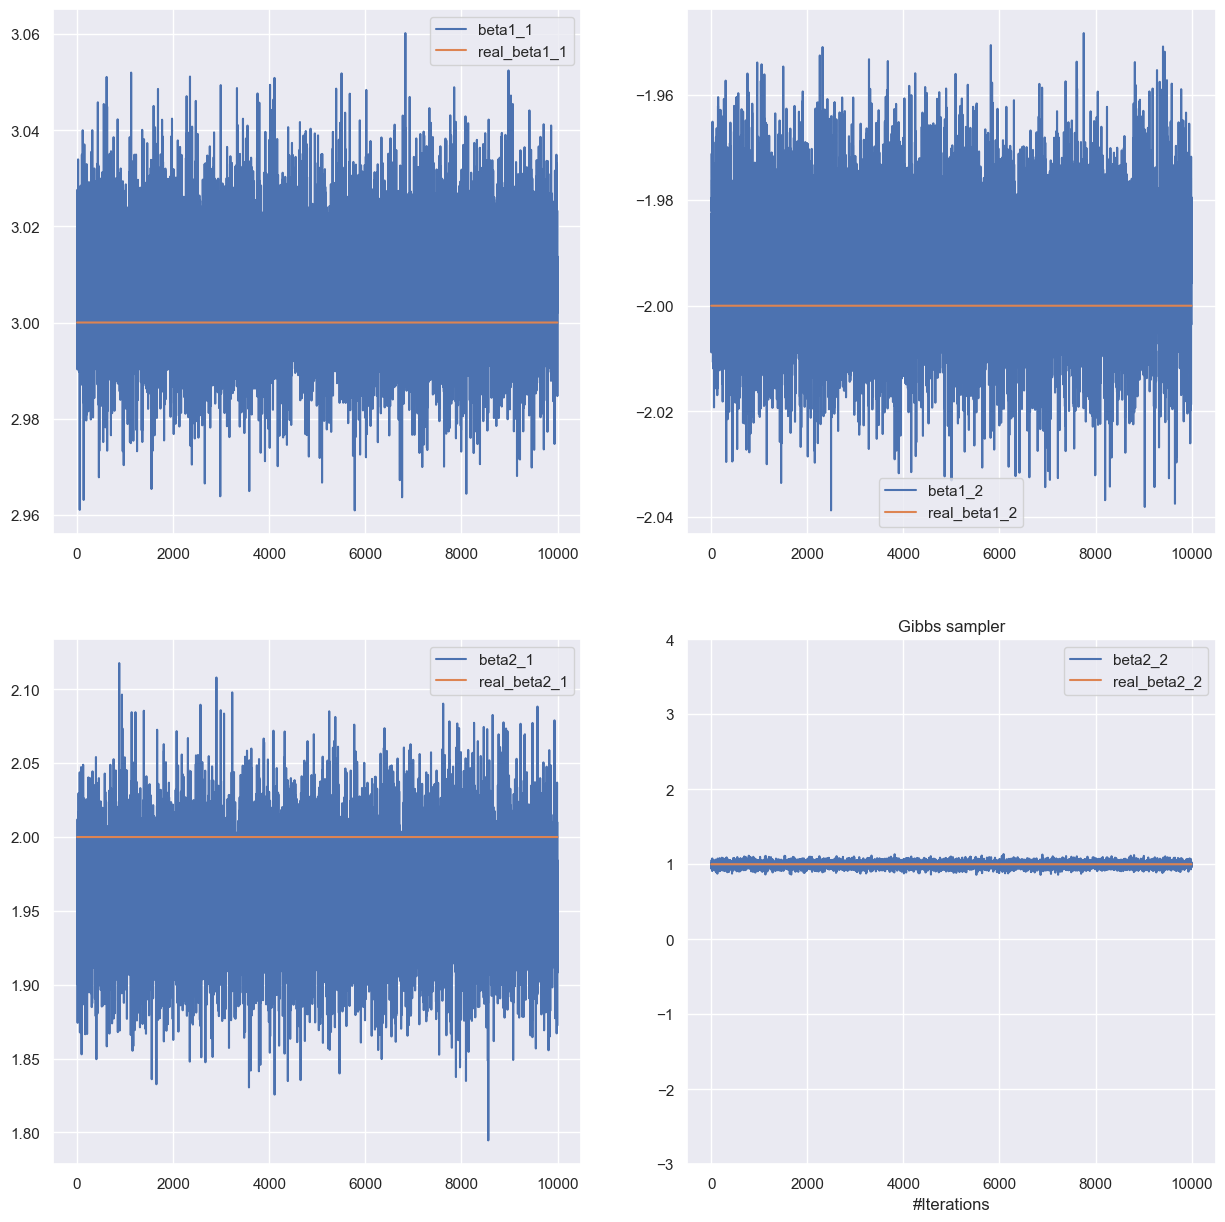

In [111]:
beta = np.hstack((beta1.reshape(-1,2),beta2.reshape(-1,2)))
plot_beta(beta)

In [116]:
print(f'Mean: {np.mean(beta1, axis=0)};')

Mean: [[ 3.00791679]
 [-1.99313584]];


In [117]:
print(f'Mean: {np.mean(beta2, axis=0)};')


Mean: [[1.9607261 ]
 [0.99508631]];


In [118]:
print(f'Mean: {np.mean(Omega, axis=0)};')

Mean: [[ 0.11608561 -0.07113485]
 [-0.07113485  1.16644408]];


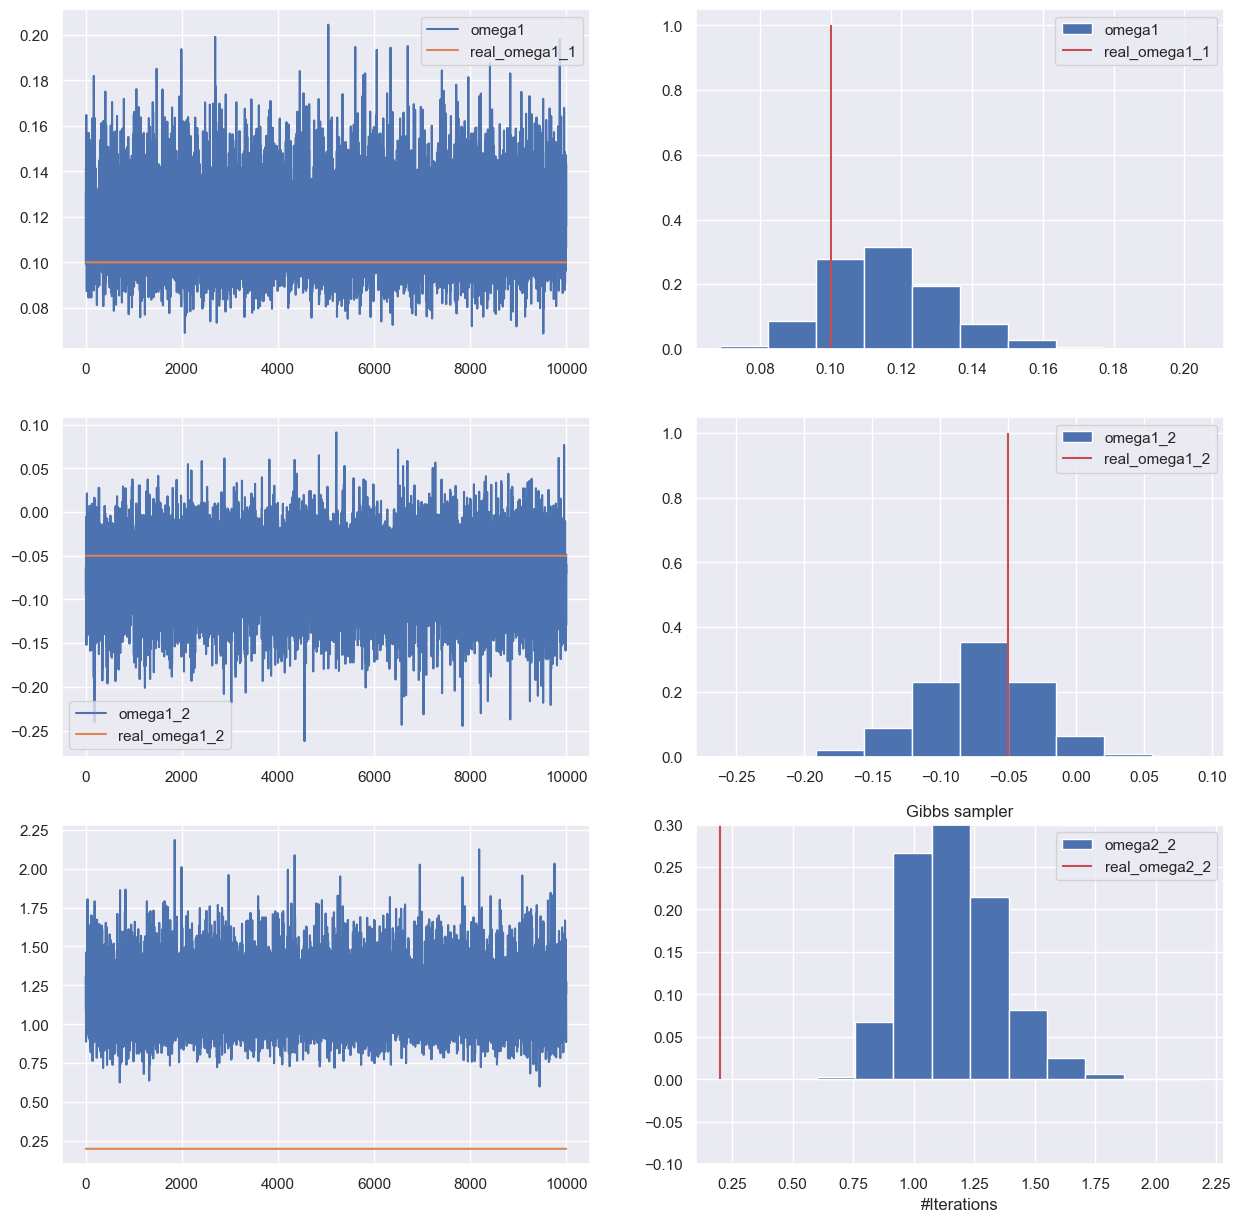

In [120]:
plot_omega(Omega)

# Direct Monte Carlo Importance Sampling Approach